In [1]:
import numpy as np
import scipy as sp
import sympy
import math
import matplotlib.pyplot as plt
from heart import heart
from valve_p import ValveinP
from three_windkessel import PressureSystem
from three_windkessel import lumped_rection

In [2]:
T=60/75
lv=heart(tau1 = 0.269*T, tau2 = 0.452*T, # tau1,2 (s)
         m1 = 1.32, m2 = 27.4, # m1,2
         Emax = 3,Emin = 0.08, # Emax,min (mmHg/mL)
        V0 = 10,T = T)# V0 (mL), T (s)

la=heart(tau1 = 0.110*T, tau2 = 0.180*T, #tau1,2
         m1 = 1.32,m2 = 13.1, # m1,2
         Emax = 0.17, Emin = 0.08, #Emax,min(mmHg/mL)
         V0 = 3,T = T) # V0 (mL), T (s)

av=ValveinP(density = 1.06, eff_length = 2.2,Aann = 5, # density, eff_length(cm), Aann
            Kvo = 0.12,Kvc = 0.15, # Kvo,Kvc
            p_oc = 0) #poc

mv=ValveinP(density = 1.06,eff_length = 1.25,Aann = 5, # density, eff_length(cm), Aann
            Kvo = 0.3,Kvc = 0.4, # Kvo,Kvc
            p_oc = 0) #poc

cap_s=PressureSystem(0.0008, 90, 1200)#C,Za,R

rv=heart(0.269*T,0.452*T, # tau1, 2
         1.32,27.4, # m1,2
         0.6,0.04, #Emax, min
         10,T) # Ks, V0 ,T

ra=heart(0.110*T,0.180*T, # tau1, 2
         1.32,13.1, # m1,2
         0.15,0.04, # Emax,min
         3, T) # Ks, V0, T

tv=ValveinP(1.06,2,6, # density, eff_length, Aann(cm2)
            0.3,0.4, # Kvo,Kvc
            0) #poc (mmHg)

pv=ValveinP(1.06,1.9,2.8, # density, eff_length, Aann(cm2)
            0.2,0.2, # Kvo,Kvc
            0) #poc
t_end=15
t = [0,t_end]
t_step = 0.01
t_span=np.arange(0,t_end,t_step)
index_range = slice(1320, 1400)
aeff_av_values = []
et_lv = []
p_lv_values=[]
time=[]
def dydt(t,y):
    v_lv = y[0]
    v_la = y[1]
    q_av = y[2]
    q_mv = y[3]
    xi_av = y[4]
    xi_mv = y[5]
    #pressure of capillaries in systemic circulation
    pa = y[6]
    v_rv = y[7]
    v_ra = y[8]
    q_tv = y[9]
    q_pv = y[10]
    xi_tv = y[11]
    xi_pv = y[12]
    #pressure of capillaries in pulmonary circulation
    pb = y[13]
    
    #calculate parameters
    #systemic
    p_la = la.p(v_la,t,0.85*T)
    p_lv = lv.p(v_lv,t)
    #p_aa: pressure at the coupling point of av and capillaries
    p_aa = cap_s.pi(q_av,pa)
    #pulmonary
    p_ra = ra.p(v_ra,t,0.85*T)
    p_rv = rv.p(v_rv,t)
    #q_cap2: flow out the capillaries of pulmonary circulation
    q_cap2 = cap_p.qout(pb,p_la)
    #p_pa: pressure at the coupling point of pv and capillaries
    p_pa = cap_p.pi(q_tv,pb)
    #q_cap1: flow out the capillaries of systemic circulation
    q_cap1 = cap_s.qout(pa,p_ra)
    
    #derivative
    #la
    dv_la = la.dv(t,v_la,q_cap2,q_mv)
    dxi_mv = mv.dxi(t,xi_mv,p_la,p_lv)
    dq_mv = mv.dq(t,q_mv,xi_mv,p_la,p_lv)
    #lv
    dv_lv = lv.dv(t,v_lv,q_mv,q_av)
    dxi_av = av.dxi(t,xi_av,p_lv,p_aa)
    dq_av = av.dq(t,q_av,xi_av,p_lv,p_aa)
    #cap sys
    dpa = cap_s.dp(t,pa,q_av,p_ra)
    #ra
    dv_ra = ra.dv(t,v_ra,q_cap1,q_tv)
    dxi_tv = tv.dxi(t,xi_tv,p_ra,p_rv)
    dq_tv = tv.dq(t,q_tv,xi_tv,p_ra,p_rv)
    #rv
    dv_rv = rv.dv(t,v_rv,q_tv,q_pv)
    dxi_pv = pv.dxi(t,xi_pv,p_rv,p_pa)
    dq_pv = pv.dq(t,q_pv,xi_pv,p_rv,p_pa)
    #cap pul
    dpb = cap_p.dp(t,pb,q_pv,p_la)
    
    #derivative vector
    dy = np.array([dv_lv, dv_la, 
                   dq_av, dq_mv, 
                   dxi_av, dxi_mv, 
                   dpa, 
                   dv_rv, dv_ra, 
                   dq_tv, dq_pv, 
                   dxi_tv, dxi_pv, 
                   dpb])
    return dy

In [3]:
rvef_surgery = []
lvef_surgery = []
sv_rv_surgery = []
sv_lv_surgery = []
p_pa_surgery = []
p_rv_surgery = []
input_para = []
v_rv_surgery = []
v_ra_surgery = []
p_lv_surgery = []
v_lv_surgery = []
v_la_surgery = []
p_ao_surgery = []
labels = []
input_para.append([12.5, 142.5,0.00875])#healthy, Za, R, C
#input_para.append([17.5, 285,0.004375])
labels = ['healthy']


In [ ]:
for r in np.arange(0.3,1,0.2):
    pul_cir = lumped_rection(C = 0.00875, trunk = 7.5,artery = 5,Rother = 142.5, r_rate = r, right= True)
    R = pul_cir.update_surgeryR()
    Za = pul_cir.update_surgeryZa()
    C = pul_cir.update_surgeryC()
    input_para.append([Za, R, C])
    if pul_cir.right is True:
        labels.append('Right resection:{:.2f}'.format(pul_cir.rr))
    else:
        labels.append('Left resection:{:.2f}'.format(pul_cir.rr))

In [ ]:
print(input_para)

In [4]:
for i in range(len(input_para)):
    cap_p=PressureSystem(input_para[i][2], input_para[i][0],input_para[i][1])#C,Za,R
    y_initial = np.array([135, 27, #lv, la
                      150, 10, #qav, qmv
                      0.01, 0.5, #xi_av, xi_mv
                      5*1333, #pa
                      180, 40, #v_rv, v_ra 
                      150, 10, #q_tv, q_pv
                      0.01, 0.5, #xi_tv, xi_pv
                      5*1333]) # pb
    #integration
    sol = sp.integrate.solve_ivp(dydt , t , y0 = y_initial , t_eval = t_span, method='LSODA')
    v_lv = sol.y[0]
    v_la = sol.y[1]
    q_av = sol.y[2]
    q_mv = sol.y[3]
    xi_av = sol.y[4]
    xi_mv = sol.y[5]
    pa = sol.y[6]
    v_rv = sol.y[7]
    v_ra = sol.y[8]
    q_tv = sol.y[9]
    q_pv = sol.y[10]
    xi_tv = sol.y[11]
    xi_pv = sol.y[12]
    pb = sol.y[13]
    p_pa = []
    p_ao = []
    p_rv = []
    p_lv = []
    for i,j in zip(sol.t,range(len(sol.t))):
        p_pa.append(cap_p.pi(q_pv[j],pb[j]))
        p_ao.append(cap_s.pi(q_av[j],pa[j]))
        p_rv.append(rv.p(v_rv[j],i))
        p_lv.append(lv.p(v_lv[j],i))
    max_rv = max(sol.y[7][index_range])
    min_rv = min(sol.y[7][index_range])
    max_lv = max(sol.y[0][index_range])
    min_lv = min(sol.y[0][index_range])
    v_ra_surgery.append(v_ra)
    v_rv_surgery.append(v_rv)
    sv_rv_surgery.append(max_rv-min_rv)
    sv_lv_surgery.append(max_lv-min_lv)
    rvef_surgery.append(sv_rv_surgery[-1]/max_rv)
    lvef_surgery.append(sv_lv_surgery[-1]/max_lv)
    p_pa_count = list(map(lambda x: x / 1333, p_pa))
    p_pa_surgery.append(p_pa_count)
    p_ao_count = list(map(lambda x: x / 1333, p_ao))
    p_ao_surgery.append(p_ao_count)
    p_rv_count = list(map(lambda x: x / 1333, p_rv))
    p_rv_surgery.append(p_rv_count)
    p_lv_count = list(map(lambda x: x / 1333, p_lv))
    p_lv_surgery.append(p_lv_count)
    v_la_surgery.append(v_la)
    v_lv_surgery.append(v_lv)

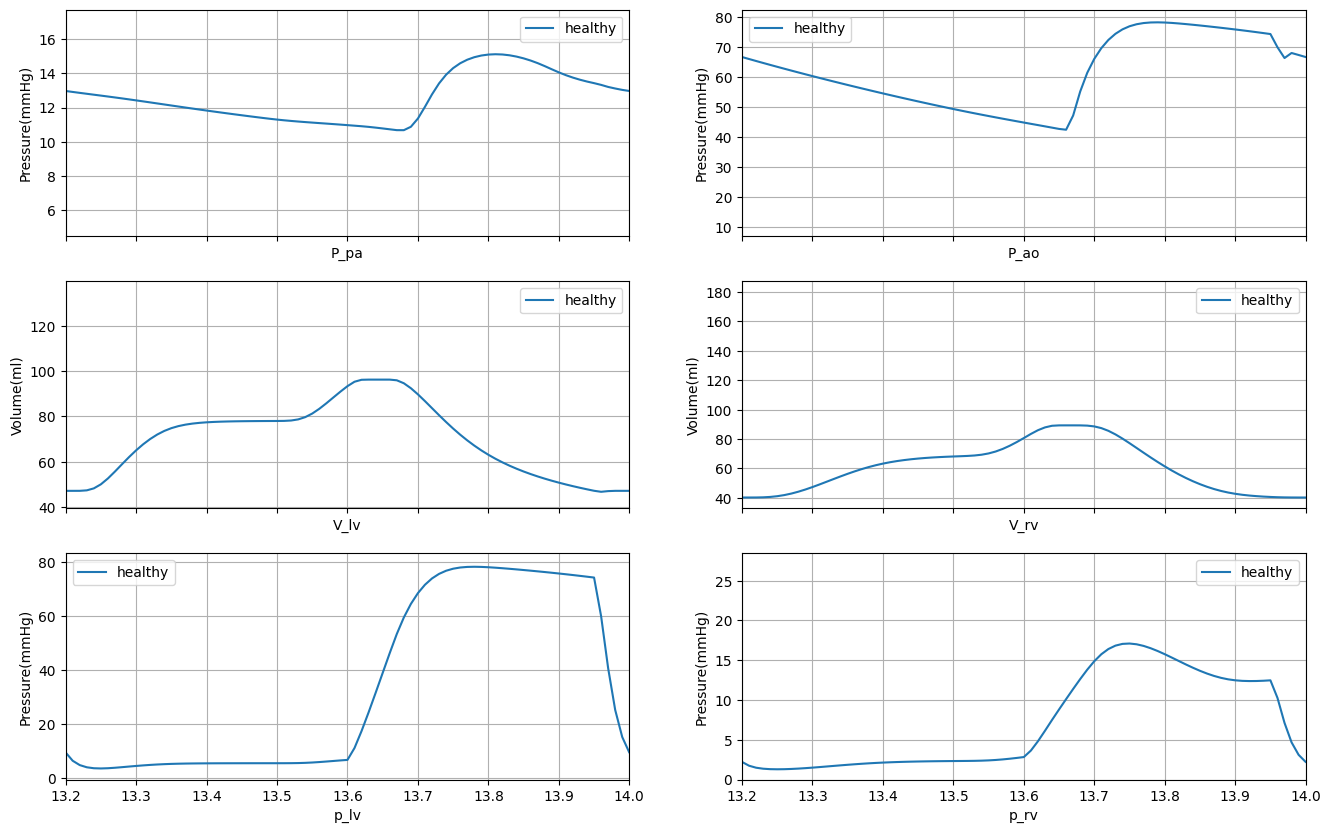

In [5]:
fig, ((ax1, ax2), (ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2, figsize=(16,10),sharex=True)
for i in range(len(p_pa_surgery)):
    ax1.plot(sol.t, p_pa_surgery[i],label =labels[i])
ax1.set_xlim(13.2,14)
ax1.set_ylabel('Pressure(mmHg)')
ax1.set_xlabel('P_pa')
ax1.legend()
ax1.grid()

for i in range(len(p_ao_surgery)):
    ax2.plot(sol.t, p_ao_surgery[i],label =labels[i])
ax2.set_xlim(13.2,14)
ax2.set_ylabel('Pressure(mmHg)')
ax2.set_xlabel('P_ao')
ax2.legend()
ax2.grid()

for i in range(len(p_pa_surgery)):
    ax3.plot(sol.t, v_lv_surgery[i],label =labels[i])
ax3.set_xlim(13.2,14)
ax3.set_ylabel('Volume(ml)')
ax3.set_xlabel('V_lv')
ax3.legend()
ax3.grid()
for i in range(len(p_pa_surgery)):
    ax4.plot(sol.t, v_rv_surgery[i],label =labels[i])
ax4.set_xlim(13.2,14)
ax4.set_ylabel('Volume(ml)')
ax4.set_xlabel('V_rv')
ax4.legend()
ax4.grid()

for i in range(len(p_pa_surgery)):
    ax5.plot(sol.t, p_lv_surgery[i],label =labels[i])
ax5.set_xlim(13.2,14)
ax5.set_ylabel('Pressure(mmHg)')
ax5.set_xlabel('p_lv')
ax5.legend()
ax5.grid()
for i in range(len(p_pa_surgery)):
    ax6.plot(sol.t, p_rv_surgery[i],label =labels[i])
ax6.set_xlim(13.2,14)
ax6.set_ylabel('Pressure(mmHg)')
ax6.set_xlabel('p_rv')
ax6.legend()
ax6.grid()
plt.show()

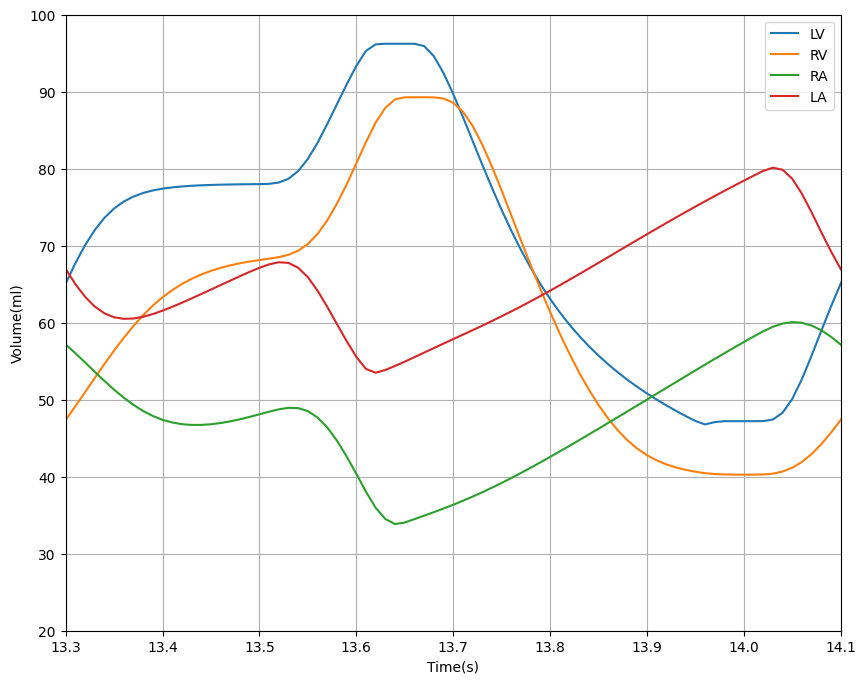

In [23]:
labels = ['LV','RV','RA','LA']
plt.figure(figsize=(10,8))
for i in range(len(p_ao_surgery)):
    plt.plot(sol.t, v_lv_surgery[i],label =labels[i])
    plt.plot(sol.t, v_rv_surgery[i],label =labels[i+1])
    plt.plot(sol.t, v_ra_surgery[i],label =labels[i+2])
    plt.plot(sol.t, v_la_surgery[i],label =labels[i+3])
plt.xlim(13.3,14.1)
plt.ylim(20,100)
plt.ylabel('Volume(ml)')
plt.xlabel('Time(s)')
plt.legend()
plt.grid()
plt.savefig('healthy_condition_volume.svg')
plt.show()

In [ ]:
print(sv_rv_surgery)
print(rvef_surgery)
print(lvef_surgery)

In [ ]:
print(input_para[0])
print(input_para[1])